![image.png](https://i.imgur.com/a3uAqnb.png)

#  **Neural Networks for Regression: Diamond Price Prediction** 💎
---

In this exercise, you will:
- Predict **diamond prices** using a neural network built with PyTorch
- Build a **Three-layer neural network regressor**
- Train the model on tabular diamond data
- Evaluate the model's performance using **multiple metrics**

---

## **Tasks Overview**

| Task | Description |
|------|-------------|
| **Task 1** | Load & Explore Data |
| **Task 2** | Data Preprocessing (Encoding & Scaling) |
| **Task 3** | Create PyTorch DataLoaders |
| **Task 4** | Build the Neural Network Model |
| **Task 5** | Define Training & Validation Functions |
| **Task 6** | Train, Evaluate & Visualize Results |

In [30]:
# Import required libraries
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


---

# Task 1: Load & Explore Data

## 📊 **About The Dataset**

This is the classic **Diamonds dataset** used for **regression tasks**.  
It contains features like **carat, cut, color, clarity, depth, table**, and physical dimensions (**x, y, z**).

The **target variable** is **price**, a continuous value we want to predict.

Dataset link: https://www.kaggle.com/datasets/natedir/diamonds/data

### 🔹**Read Data**

In [10]:
# Download latest version
path = kagglehub.dataset_download("natedir/diamonds")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/diamonds.csv")
df = df.drop('Unnamed: 0', axis=1)
df.head()

Using Colab cache for faster access to the 'diamonds' dataset.
Path to dataset files: /kaggle/input/diamonds


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


---

# Task 2: Data Preprocessing

### 🔹**Prepare Data**

> Before training the model, we'll prepare the data by **encoding categorical features** and **scaling numerical features** to ensure stable and efficient neural network training.

**Preprocessing Checklist:**

| Step | Action |
|------|--------|
| 1 | Encode categorical columns (cut, color, clarity) |
| 2 | Scale numerical features (but NOT the target!) |
| 3 | Split into features (X) and target (y) |
| 4 | Convert to PyTorch tensors |

In [12]:
# TODO: Encode categorical features using LabelEncoder
# [HINT]: Use select_dtypes to find categorical columns, then loop through them

categorical_cols = df.select_dtypes(include="object").columns  # <Replace None with your code>

for col in categorical_cols:
  print(f"Encoding column: {col}")
  le = LabelEncoder()
  # TODO: Apply fit_transform to encode the column
  df[col] = le.fit_transform(df[col])  # <Replace None with your code>

df.head()

Encoding column: cut
Encoding column: color
Encoding column: clarity


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [13]:
# TODO: Standardize features using StandardScaler (DON'T scale the target!)
# [HINT]: Select numerical columns, but drop "price" from the list

numerical_cols =  df.select_dtypes(include=["number"]).columns.drop("price")
scaler = StandardScaler()

# TODO: Apply fit_transform to scale the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols]) # <Replace None with your code>

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,-1.198168,-0.538099,-0.937163,-0.484264,-0.174092,-1.099672,326,-1.587837,-1.536196,-1.571129
1,-1.240361,0.434949,-0.937163,-1.064117,-1.360738,1.585529,326,-1.641325,-1.658774,-1.741175
2,-1.198168,-1.511147,-0.937163,0.095589,-3.385019,3.375663,327,-1.498691,-1.457395,-1.741175
3,-1.071587,0.434949,1.414272,0.675442,0.454133,0.242928,334,-1.364971,-1.317305,-1.287720
4,-1.029394,-1.511147,2.002131,-0.484264,1.082358,0.242928,335,-1.240167,-1.212238,-1.117674


> After preprocessing data, we'll first split the dataset into features and target labels, apply a train–test split, and then convert the data into PyTorch tensors

In [14]:

# TODO: Split features from target
X = df.drop("price", axis=1)  # <Replace None with your code>
y = df["price"]  # <Replace None with your code>
X,y
# TODO: Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)  # <Replace None with your code>

# TODO: Transform to PyTorch tensors with dtype=torch.float32 ,(dataframes can NOT be passed to torch tensors, .values is required to transfer them to ndarrys)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test  = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test  = torch.tensor(y_test.values, dtype=torch.float32)

---

# Task 3: Create PyTorch DataLoaders

> After converting the data into tensors, we group features and labels into **TensorDataset** objects.  
We then use **DataLoaders** to load the data in mini-batches for efficient training and evaluation.

**Why use DataLoaders?**
- Handles **batching** automatically
- Enables **shuffling** of training data
- Makes training loops cleaner and more efficient

In [15]:
# TODO: Create TensorDatasets for training and testing
# [HINT]: Use TensorDataset(features, labels)
train_dataset = TensorDataset(X_train,y_train) # <Replace None with your code>
test_dataset = TensorDataset(X_test, y_test)   # <Replace None with your code>

# TODO: Create DataLoaders with batch_size=32
# [HINT]: shuffle=True for training, shuffle=False for testing
train_loader = DataLoader(train_dataset,batch_size=32, shuffle = True)  # <Replace None with your code>
test_loader = DataLoader(test_dataset,batch_size=32, shuffle = False)   # <Replace None with your code>

# Print dataset sizes
print("Train dataset:", len(train_dataset))
print("Test dataset:", len(test_dataset))

# Get the first batch from the training DataLoader
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Train dataset: 43152
Test dataset: 10788
Training batch input shape: torch.Size([32, 9])
Training batch labels shape: torch.Size([32])


> Data is now ready for the model! Let's build the model class.


---

# Task 4: Build the Neural Network Model

### 🔹**Model Class**

Let's create the **architecture of our model** by implementing a **three-layer neural network regressor**.

For regression, the key differences from classification are:
- **Output layer** produces a single continuous value (not class probabilities)
- **No softmax** is needed at the output
- We use **MSE (Mean Squared Error)** loss instead of Cross-Entropy

**Architecture Overview:**
```
Input (9 features) → Linear → ReLU → Linear → ReLU → Linear → Output (1 value)
```

In [33]:
from torch import nn
class NN3Layer(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(NN3Layer, self).__init__()
    # TODO: Define the first linear layer: input_dim -> hidden_dim
    self.layer1 = nn.Linear(input_dim,hidden_dim)  # <Replace None with your code>

    # TODO: Define the second linear layer: hidden_dim -> hidden_dim
    self.layer2 =nn.Linear(hidden_dim,hidden_dim) # <Replace None with your code>

    # TODO: Define the output layer: hidden_dim -> 1 (single value for regression)
    self.layer3 = nn.Linear(hidden_dim, 1)   # <Replace None with your code>

    # TODO: Define ReLU activation
    self.relu = nn.ReLU()  # <Replace None with your code>

  def forward(self, x):
    # TODO: First hidden layer with ReLU
    a1 =self.relu(self.layer1(x)) # <Replace None with your code>

    # TODO: Second hidden layer with ReLU
    a2 =self.relu(self.layer2(a1)) # <Replace None with your code>

    # TODO: Output layer (no activation for regression)
    output = self.layer3(a2)  # <Replace None with your code>

    return output

---

# Task 5: Define Training & Validation Functions

### 🔹**Training Loop**

> The training loop performs **forward pass**, computes **loss**, does **backpropagation**, and **updates weights**.

**Training Steps per Batch:**
1. Move data to device (GPU)
2. Forward pass: Get model predictions
3. Compute loss (MSE for regression)
4. Zero gradients, Backward pass, Update weights

In [34]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
  # TODO: Set the model to training mode
  model.train()

  running_loss = 0.0

  for X_batch, y_batch in train_loader:
    # TODO: Move batch to the selected device
    X_batch = X_batch.to(device) # <Replace None with your code>
    y_batch = y_batch.view(-1,1).to(device) # <Replace None with your code> [HINT: reshape to (-1, 1)]

    # TODO: Forward pass - get model predictions
    outputs =model(X_batch)  # <Replace None with your code>

    # TODO: Compute loss using criterion
    loss =criterion(outputs,y_batch)  # <Replace None with your code>

    # Backward pass & optimization
    optimizer.zero_grad()   # Clear previous gradients
    loss.backward()         # Compute gradients
    optimizer.step()        # Update model parameters

    running_loss += loss.item()

  # Calculate average loss over all batches
  avg_loss = running_loss / len(train_loader)

  return avg_loss

### 🔹**Validation Loop**

> The validation loop is similar to training, but with key differences:
> - Model is set to **evaluation mode** (`model.eval()`)
> - We use `torch.no_grad()` to **disable gradient computation**
> - No weight updates happen, we just evaluate performance

In [35]:
def validate(model, criterion, test_loader, device):
  # TODO: Set the model to evaluation mode
  model.eval()

  running_loss = 0.0

  # TODO: Disable gradient computation using torch.no_grad()
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      # TODO: Move data to device
      X_batch = X_batch.to(device)  # <Replace None with your code>
      y_batch = y_batch.view(-1,1).to(device)  # <Replace None with your code> [HINT: reshape to (-1, 1)]

      # TODO: Forward pass - get model predictions
      outputs = model(X_batch)  # <Replace None with your code>

      # TODO: Compute loss using criterion
      loss =  criterion(outputs,y_batch)  # y_batch

      running_loss += loss.item()

  avg_loss = running_loss / len(test_loader)

  return avg_loss

---

# Task 6: Train and Evaluate the Model

### 🔹**Model Setup**

> Now let's put everything together! We'll:
> 1. Set up the device (GPU if available)
> 2. Instantiate our model
> 3. Define the loss function and optimizer
> 4. Run the training loop

In [36]:
# TODO: Set up the device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # <Replace None with your code>

In [37]:
# Model parameters
input_dim = X_train.shape[1]   # Number of tabular features
hidden_dim = 64                # Design choice (feel free to experiment!)

# TODO: Instantiate the model and move it to the device
model = NN3Layer(input_dim,hidden_dim).to(device)
# Print the model architecture
print("Model Architecture:\n")
print(model)

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")

Model Architecture:

NN3Layer(
  (layer1): Linear(in_features=9, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 4865


In [38]:
# Hyperparameters (feel free to experiment!)
num_epochs = 20
learning_rate = 0.001

In [39]:
# TODO: Define criterion (loss function) - use MSELoss for regression
criterion = nn.MSELoss()  # <Replace None with your code>

# TODO: Define optimizer - use AdamW with the model parameters and learning rate
optimizer = AdamW(model.parameters(), learning_rate)  # <Replace None with your code>

### 🔹**Run Training**

> Now we're ready to train! The training loop will:
> - Train for the specified number of epochs
> - Track both training and validation loss
> - Print progress after each epoch

In [40]:
# Run Training
train_losses = []
val_losses = []

print('Starting Training...')
for epoch in range(num_epochs):
  # TODO: Train one epoch using the train_one_epoch function
  train_loss = train_one_epoch(model,optimizer,criterion,train_loader,device) # <Replace None with your code>

  # TODO: Validate using the validate function
  val_loss = validate(model, criterion,test_loader,device)  # <Replace None with your code>

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training Complete!')

Starting Training...
Epoch [1/20], Train Loss: 9820089.7086, Val Loss: 1545547.6278
Epoch [2/20], Train Loss: 1711900.4816, Val Loss: 1384189.3474
Epoch [3/20], Train Loss: 1611493.9105, Val Loss: 1336099.8648
Epoch [4/20], Train Loss: 1553635.7053, Val Loss: 1315045.4320
Epoch [5/20], Train Loss: 1514023.3148, Val Loss: 1292058.2480
Epoch [6/20], Train Loss: 1473245.0612, Val Loss: 1274829.8246
Epoch [7/20], Train Loss: 1444546.7708, Val Loss: 1259417.9777
Epoch [8/20], Train Loss: 1414347.8997, Val Loss: 1253388.7623
Epoch [9/20], Train Loss: 1389103.0653, Val Loss: 1235237.4938
Epoch [10/20], Train Loss: 1366611.3435, Val Loss: 1225127.2332
Epoch [11/20], Train Loss: 1349683.3930, Val Loss: 1217000.0349
Epoch [12/20], Train Loss: 1331803.9375, Val Loss: 1261918.0847
Epoch [13/20], Train Loss: 1321216.0894, Val Loss: 1205093.8559
Epoch [14/20], Train Loss: 1308059.0911, Val Loss: 1199504.6933
Epoch [15/20], Train Loss: 1296524.8385, Val Loss: 1189463.3625
Epoch [16/20], Train Loss: 1

### 🔹**Visualize Results**

> Let's plot the training and validation losses to see how our model learned over time.

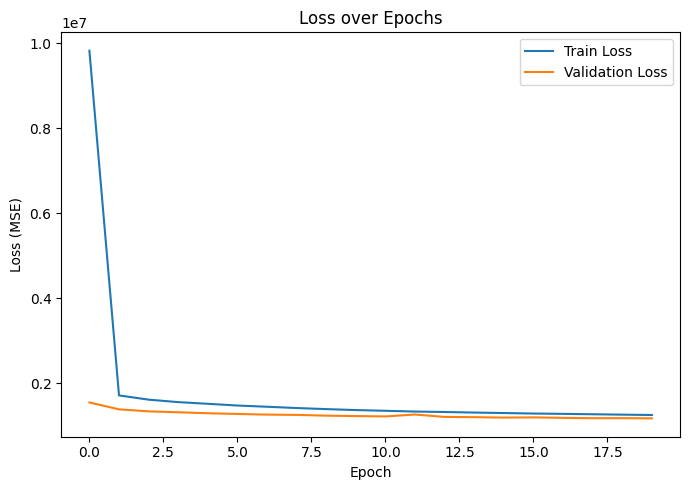

In [43]:
# Plotting results
plt.figure(figsize=(7, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()

### 📊 **Evaluate with More Metrics**

> Beyond MSE loss, we can evaluate our regression model using additional metrics:
> - **MAE (Mean Absolute Error)**: Average absolute difference between predictions and actual values
> - **RMSE (Root Mean Squared Error)**: Square root of MSE, in the same units as the target
> - **R² Score**: Proportion of variance explained by the model (1.0 = perfect)

In [41]:
# Get predictions on test set
model.eval()
with torch.no_grad():
  # TODO: Get predictions for X_test
  # [HINT]: Move X_test to device, pass through model, then move back to CPU
  predictions = model(X_test.to(device)).cpu().numpy()  # <Replace None with your code>

# TODO: Calculate evaluation metrics
# [HINT]: Use sklearn metrics - mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test.numpy(),predictions)   # <Replace None with your code>
mse = mean_squared_error(y_test.numpy(),predictions)   # <Replace None with your code>
rmse = np.sqrt(mse)# <Replace None with your code> [HINT: use np.sqrt()]
r2 = r2_score(y_test.numpy(),predictions)    # <Replace None with your code>

print("Model Evaluation")
print(f"  MAE:  ${mae:.2f}")
print(f"  MSE:  {mse:.2f}")
print(f"  RMSE: ${rmse:.2f}")
print(f"  R2:   {r2:.4f}")

Model Evaluation
  MAE:  $591.27
  MSE:  1174046.12
  RMSE: $1083.53
  R2:   0.9261


### 📈 **Visualize: Predicted vs Actual**

> Let's visualize how well our model's predictions match the actual diamond prices.
> - A **perfect model** would have all points on the diagonal line
> - Points **above the line** = model underestimated the price
> - Points **below the line** = model overestimated the price

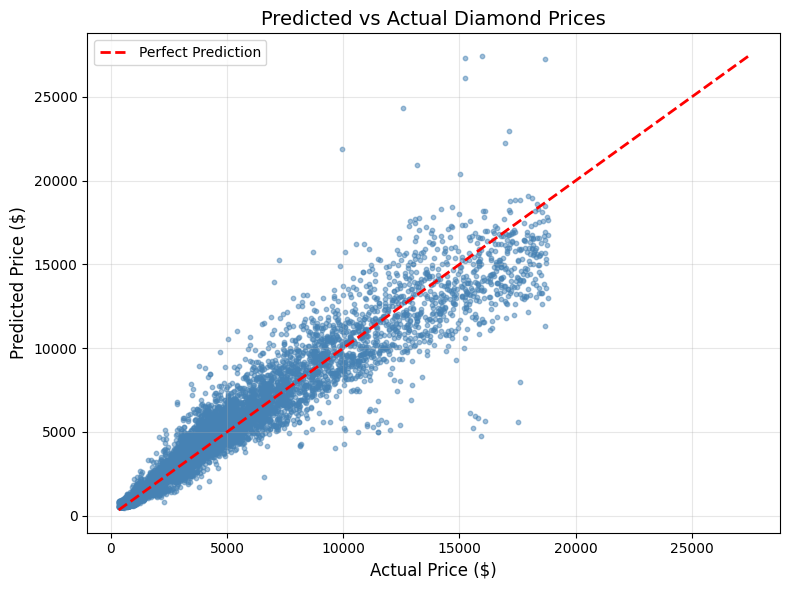

In [42]:
# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))

# Plot: Predicted vs Actual scatter
plt.scatter(y_test.numpy(), predictions.flatten(), alpha=0.5, s=10, c='steelblue')

# Add perfect prediction line
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title('Predicted vs Actual Diamond Prices', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Contribution: Yara Alzahrani & Sattam Altwaim** :)

![image.jpeg](https://i.imgur.com/Q4egy5l.jpeg)
